# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter = ';' ) #delimited by ;

# Load in the feature summary file.
feat_info = feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter = ';') #delimited by ;

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print ('General demographics data shape:', azdias.shape)
print ('Feature summary data shape:', feat_info.shape)

General demographics data shape: (891221, 85)
Feature summary data shape: (85, 4)


In [4]:
print ('General demographics first 1 row:')
azdias.head(1)

General demographics first 1 row:


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
print ('Feature summary first 1 row:')
feat_info.head(1)

Feature summary first 1 row:


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"


In [6]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
Nan_azdias = azdias.isnull().sum(axis = 0)

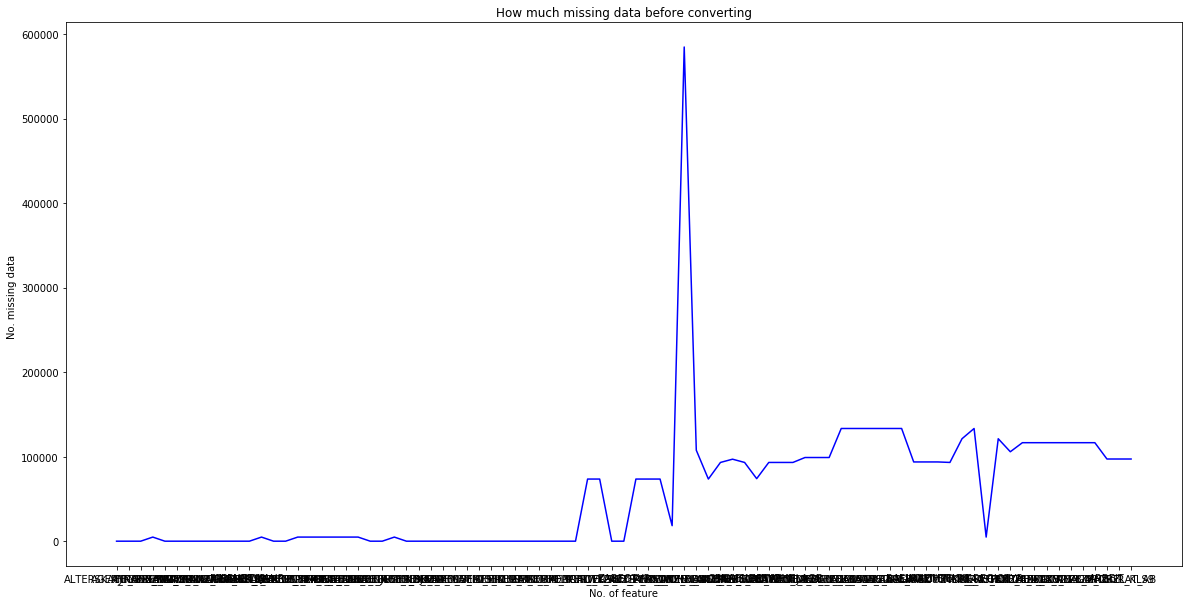

In [8]:
# To identify missing values before converting
plt.figure(figsize =(20,10))
plt.plot(Nan_azdias, color='b')
plt.xlabel('No. of feature')
plt.ylabel('No. missing data ')
plt.title('How much missing data before converting')
plt.show()

In [3]:
# Crate a copy from azdias
az = azdias

In [4]:
# Identify missing or unknown data values and convert them to NaNs

unknown_list = [] # List to save counting on
for az_r in range(az.shape[1]): # For to 85
    unknown_counts = 0 # Counts missing values
    az_col = az.columns[az_r] #Column value
    mis_cols = feat_info['missing_or_unknown'][az_r] #Missing in each colmun
    mis_len = len(mis_cols)-1 #length of a string without ending
    mis_vals = mis_cols[1:mis_len].split(',') #Missing value sparted by ,
    az_vals = az[az_col].value_counts(dropna=False) #Values in each column
    for mis_val in mis_vals: # To go inside each value in mis value
        if (mis_val.startswith('-') and mis_val[1:].isdigit()) or mis_val.isdigit(): #To avoid charcters
            if int(mis_val) in az_vals: #Change charcters to int to fix the int values
                unknown_count = az[az_col].value_counts()[int(mis_val)] #To save missing values no. in counter
                unknown_counts += unknown_count  #To save the counter in values counter
                az[az_col]=az[az_col].replace(int(mis_val),np.nan) #Replace values to Nan
        else : 
            if mis_val in az_vals or '' in az_vals: #To check about charcters values
                unknown_count = az[az_col].value_counts()[mis_val] #To save missing  charcters values no. in counter
                unknown_counts += unknown_count #To save the counter in values counter
                az[az_col]=az[az_col].replace(mis_val,np.nan) #Replace values to Nan
                
    unknown_list.append(unknown_counts) #Append counter in list

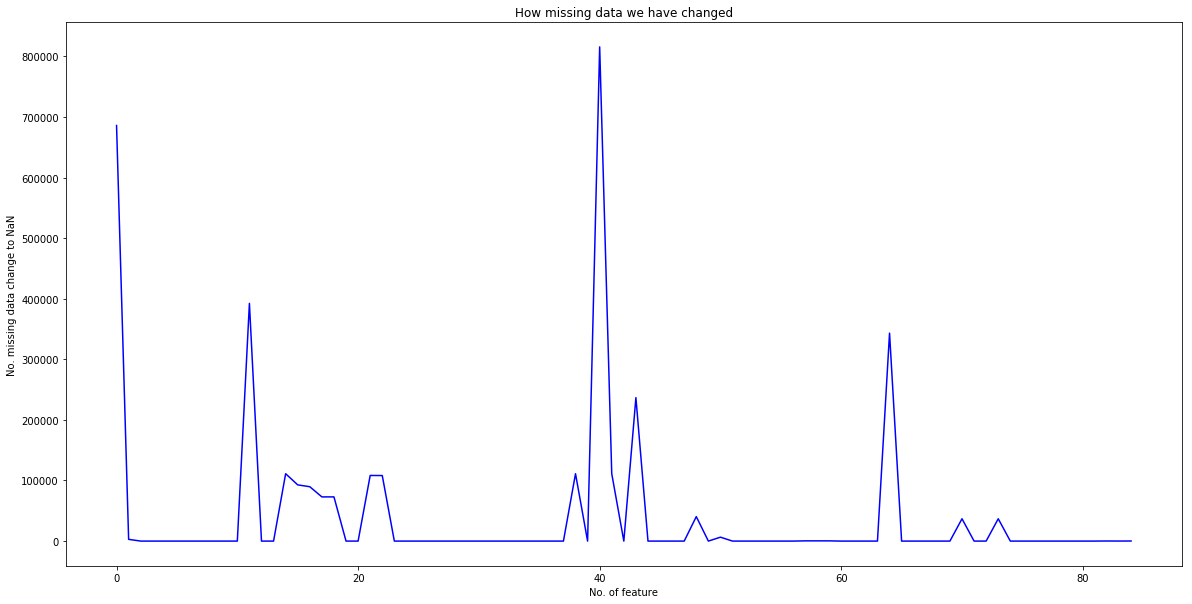

In [11]:
# To plt unknown list that I have created above for the values that we changed.

plt.figure(figsize =(20,10))
plt.plot(unknown_list, color='b')
plt.xlabel('No. of feature')
plt.ylabel('No. missing data change to NaN')
plt.title('How missing data we have changed')
plt.show()

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [6]:
# To identify missing values after converting

Nan_list = az.isnull().sum(axis = 0)

In [7]:
# To change the value to persent

for i in range(Nan_list.shape[0]):
    Nan_list[i] = (Nan_list[i]*100)/az.shape[0]

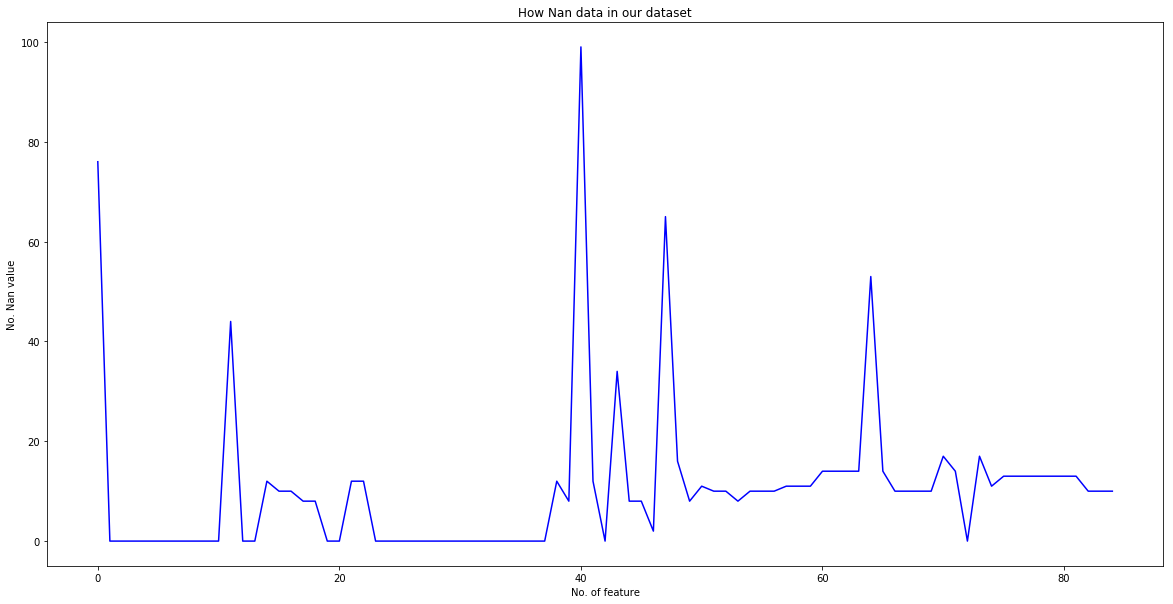

In [14]:
# To plot nan values persent for each features

plt.figure(figsize =(20,10))
plt.plot(Nan_list.values, color='b')
plt.xlabel('No. of feature')
plt.ylabel('No. Nan value')
plt.title('How Nan data in our dataset')
plt.show()

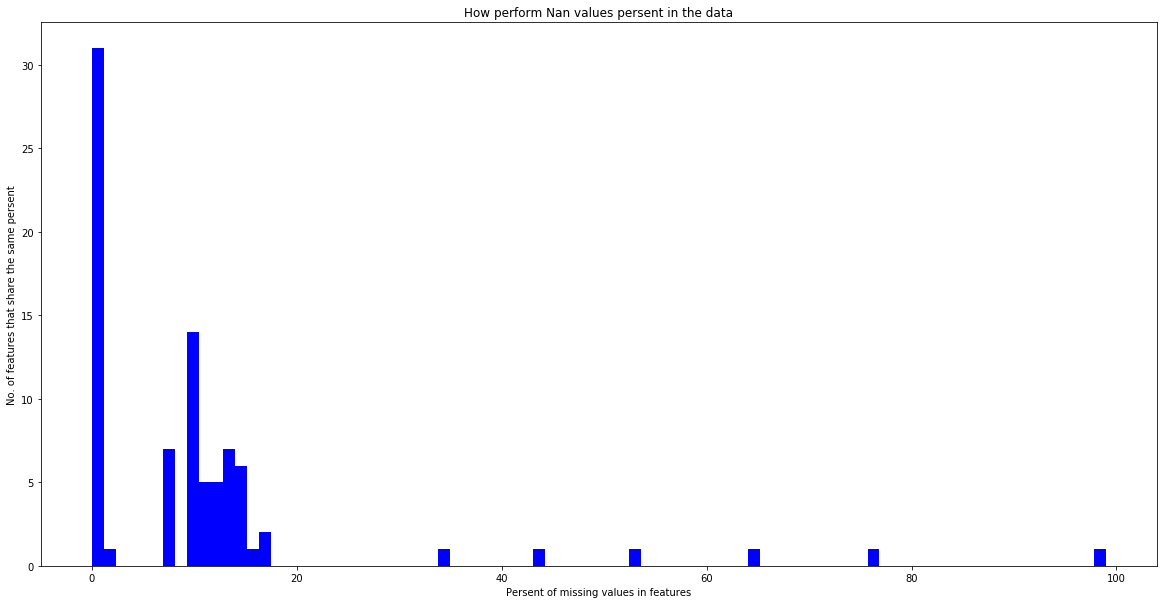

In [15]:
# Visualize the distribution of missing values present 

plt.figure(figsize =(20,10))
plt.xlabel('Persent of missing values in features')
plt.ylabel('No. of features that share the same persent')
plt.title('How perform Nan values persent in the data')
plt.hist(Nan_list, 85, facecolor='blue')
plt.show()

In [8]:
# Investigate patterns in the amount of missing data in each column.

# Which is the column are more than 15 persent of missing values

for i in range(Nan_list.shape[0]):
    if Nan_list[i] >= 15:
        print('Feature', Nan_list.index[i], 'Have', Nan_list[i] , '% of missing data')

Feature AGER_TYP Have 76 % of missing data
Feature GEBURTSJAHR Have 44 % of missing data
Feature TITEL_KZ Have 99 % of missing data
Feature ALTER_HH Have 34 % of missing data
Feature KK_KUNDENTYP Have 65 % of missing data
Feature W_KEIT_KIND_HH Have 16 % of missing data
Feature KBA05_BAUMAX Have 53 % of missing data
Feature KKK Have 17 % of missing data
Feature REGIOTYP Have 17 % of missing data


In [9]:
# Investigate patterns in the amount of missing data in each column.

# Which is the column are between 11 and 15 persent of missing values

for i in range(Nan_list.shape[0]):
    if Nan_list[i] >= 11 and Nan_list[i] < 15:
        print('Feature', Nan_list.index[i], 'Have', Nan_list[i] , '% of missing data')

Feature HEALTH_TYP Have 12 % of missing data
Feature NATIONALITAET_KZ Have 12 % of missing data
Feature PRAEGENDE_JUGENDJAHRE Have 12 % of missing data
Feature SHOPPER_TYP Have 12 % of missing data
Feature VERS_TYP Have 12 % of missing data
Feature ANZ_HAUSHALTE_AKTIV Have 11 % of missing data
Feature CAMEO_DEUG_2015 Have 11 % of missing data
Feature CAMEO_DEU_2015 Have 11 % of missing data
Feature CAMEO_INTL_2015 Have 11 % of missing data
Feature KBA05_ANTG1 Have 14 % of missing data
Feature KBA05_ANTG2 Have 14 % of missing data
Feature KBA05_ANTG3 Have 14 % of missing data
Feature KBA05_ANTG4 Have 14 % of missing data
Feature KBA05_GBZ Have 14 % of missing data
Feature MOBI_REGIO Have 14 % of missing data
Feature KBA13_ANZAHL_PKW Have 11 % of missing data
Feature PLZ8_ANTG1 Have 13 % of missing data
Feature PLZ8_ANTG2 Have 13 % of missing data
Feature PLZ8_ANTG3 Have 13 % of missing data
Feature PLZ8_ANTG4 Have 13 % of missing data
Feature PLZ8_BAUMAX Have 13 % of missing data
Featur

In [18]:
# Investigate patterns in the amount of missing data in each column.
# Which is the column are 10 or less but not zero persent of missing values
for i in range(Nan_list.shape[0]):
    if Nan_list[i] >= 1 and Nan_list[i] < 11:
        print('Feature', Nan_list.index[i], 'Have', Nan_list[i] , '% of missing data')

Feature LP_LEBENSPHASE_FEIN Have 10 % of missing data
Feature LP_LEBENSPHASE_GROB Have 10 % of missing data
Feature LP_FAMILIE_FEIN Have 8 % of missing data
Feature LP_FAMILIE_GROB Have 8 % of missing data
Feature SOHO_KZ Have 8 % of missing data
Feature ANZ_PERSONEN Have 8 % of missing data
Feature ANZ_TITEL Have 8 % of missing data
Feature HH_EINKOMMEN_SCORE Have 2 % of missing data
Feature WOHNDAUER_2008 Have 8 % of missing data
Feature ANZ_HH_TITEL Have 10 % of missing data
Feature GEBAEUDETYP Have 10 % of missing data
Feature KONSUMNAEHE Have 8 % of missing data
Feature MIN_GEBAEUDEJAHR Have 10 % of missing data
Feature OST_WEST_KZ Have 10 % of missing data
Feature WOHNLAGE Have 10 % of missing data
Feature BALLRAUM Have 10 % of missing data
Feature EWDICHTE Have 10 % of missing data
Feature INNENSTADT Have 10 % of missing data
Feature GEBAEUDETYP_RASTER Have 10 % of missing data
Feature ARBEIT Have 10 % of missing data
Feature ORTSGR_KLS9 Have 10 % of missing data
Feature RELAT_A

In [10]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
drop_cols = []
for i in range(Nan_list.shape[0]):
    if Nan_list[i] >= 18:
        drop_cols.append(Nan_list.index[i])
az_out = az.drop(drop_cols,axis=1)

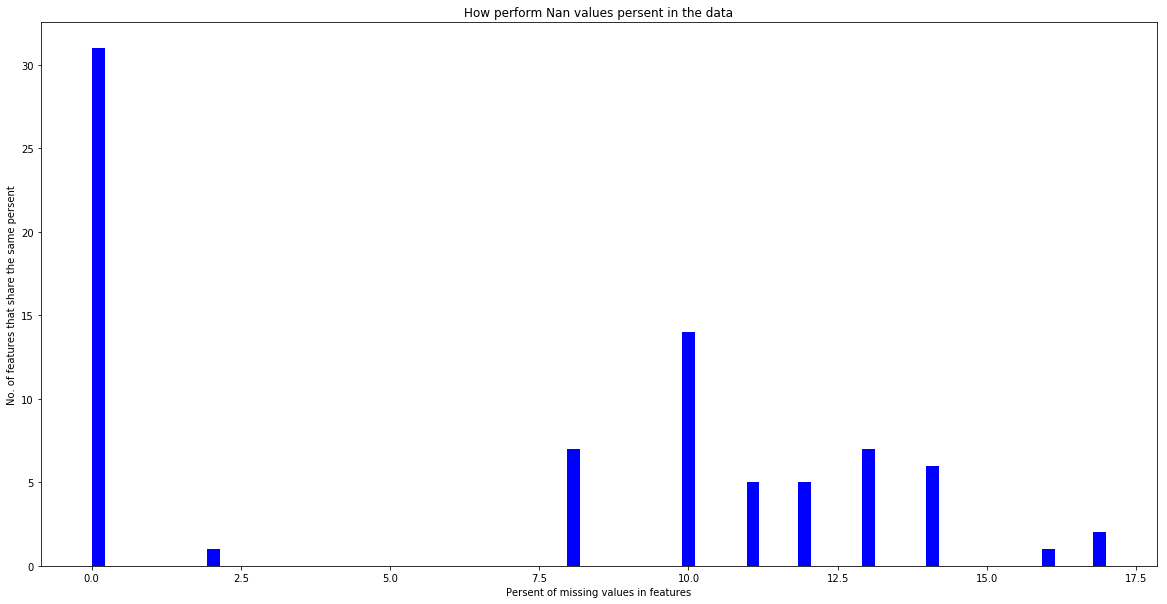

In [11]:
Nan_list_after_drop = az_out.isnull().sum(axis = 0)
for i in range(Nan_list_after_drop.shape[0]):
    Nan_list_after_drop[i] = (Nan_list_after_drop[i]*100)/az.shape[0]

plt.figure(figsize =(20,10))
plt.xlabel('Persent of missing values in features')
plt.ylabel('No. of features that share the same persent')
plt.title('How perform Nan values persent in the data')
plt.hist(Nan_list_after_drop, 79, facecolor='blue')
plt.show()

#### Discussion 1.1.2: Assess Missing Data in Each Column <br>
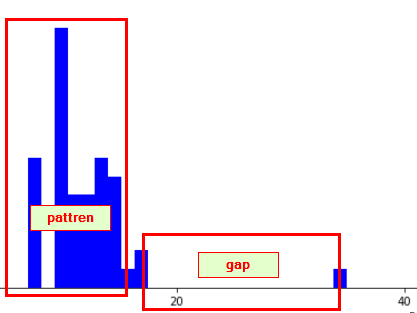

<br>
##### Are there any patterns in missing values? <br>
Indeed **there a patterns in missing vlaues**, as look here in the hist graph many features exist in 8,10,11,12,13,14 missing features so there a patterns here (also when you dive inside the features will see some relations i.e ' PLZ8, CAMEO, KBA05'.<br><br>
##### Which columns were removed from the dataset?<br>
As appear in the hist graph there a big gap between features **are less than 17% missing values to 34% missing values**. So for any features that more than 17 % missing values **must be deleted ('AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX').**<br><br>
And for features are between 5-14 as discussed above there a patterns that stop me to drop them, but for features are 15,16,17 % of missing values when I check about them I found they are a valuable informations:<br>
KBA13_ANZAHL_PKW Number of cars in the PLZ8 region<br>
REGIOTYP Neighborhood typology<br>
W_KEIT_KIND_HH Likelihood of children in household<br>
<br>
So I decided to it would be better to **keep them ** and impute them latter.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. Make sure you report your observations in the discussion section. **Either way, you should continue your analysis below using just the subset of the data with few or no missing values.**

In [12]:
# How much data is missing in each row of the dataset?
Rows_na = az_out.isnull().sum(axis = 1)
Rows_na.describe()

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

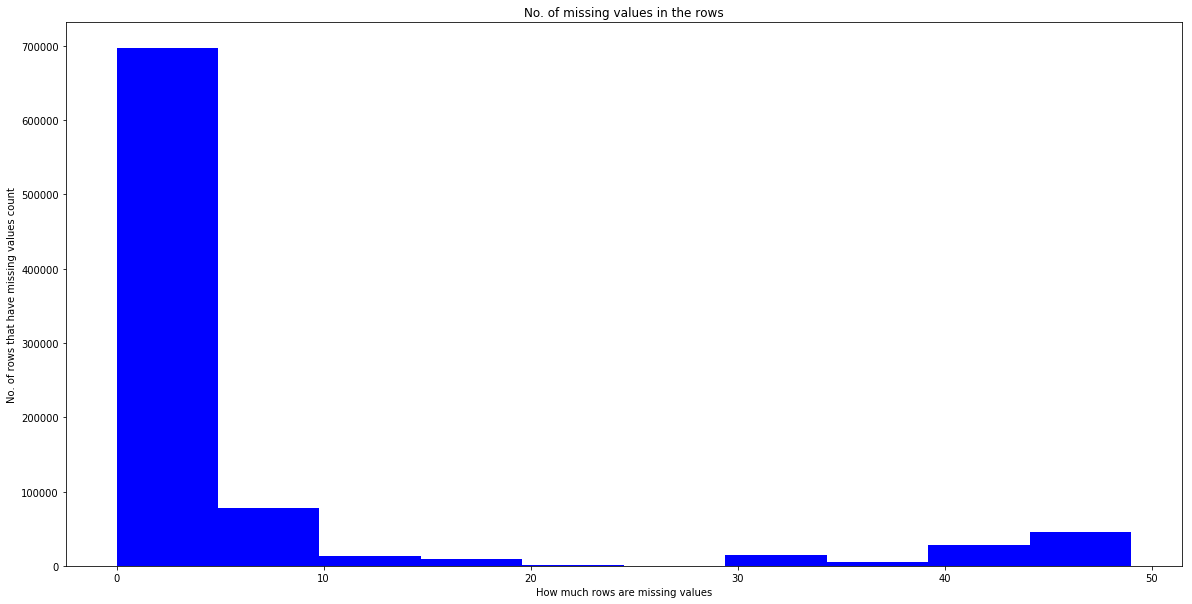

In [22]:
plt.figure(figsize =(20,10))
plt.xlabel('How much rows are missing values')
plt.ylabel('No. of rows that have missing values count')
plt.title('No. of missing values in the rows')
plt.hist(Rows_na, facecolor='blue')
plt.show()

In [13]:
# For rows are more or less than 10 missing features save them in two grouops
gruop1 = []
gruop2 = []
for i in range(Rows_na.shape[0]):
    if Rows_na[i] >= 10:
        gruop1.append(Rows_na.index[i])
    else :gruop2.append(Rows_na.index[i])       

In [14]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

az_grp1 = az_out.loc[gruop1]
az_grp2 = az_out.loc[gruop2]

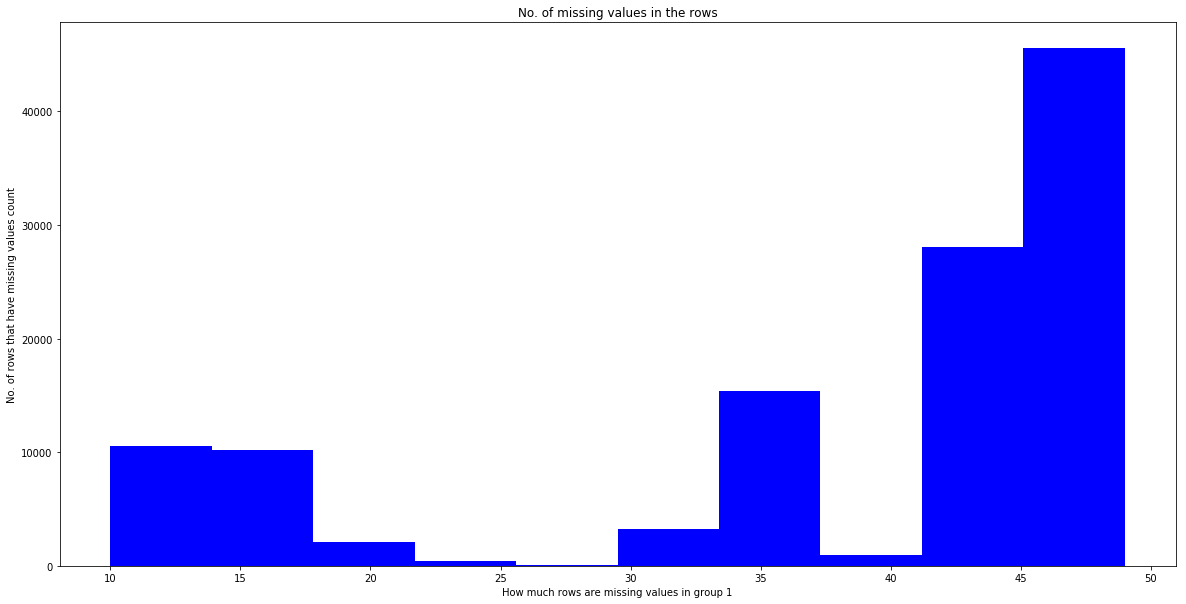

In [15]:
Nan_list_grp1 = az_grp1.isnull().sum(axis = 1)
plt.figure(figsize =(20,10))
plt.xlabel('How much rows are missing values in group 1')
plt.ylabel('No. of rows that have missing values count')
plt.title('No. of missing values in the rows')
plt.hist(Nan_list_grp1, facecolor='blue')
plt.show()

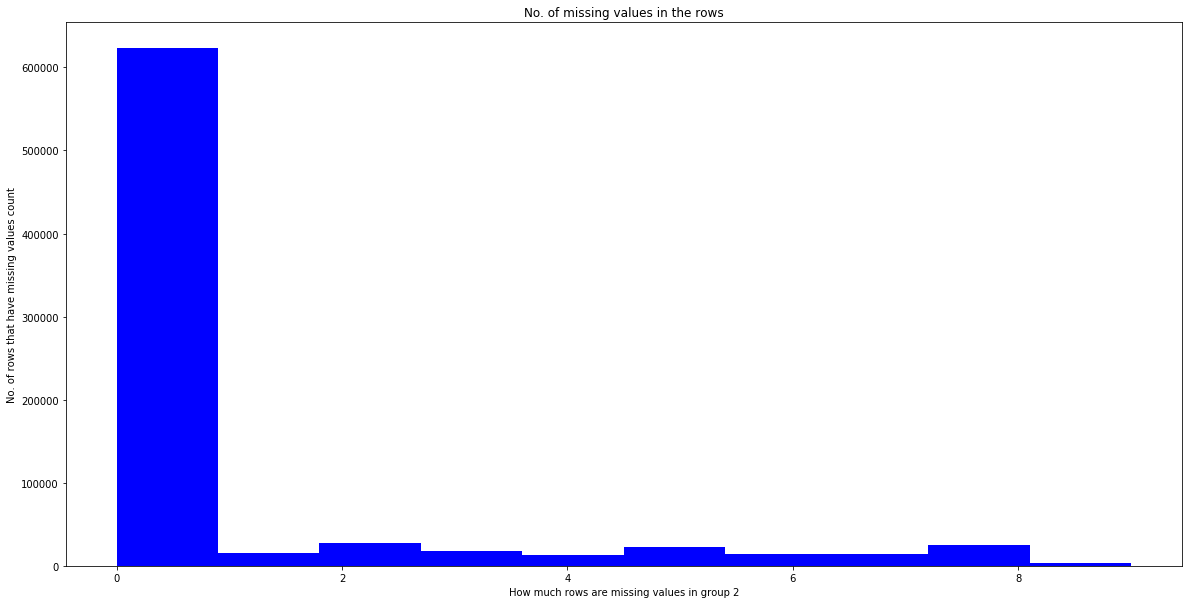

In [16]:
Nan_list_grp2 = az_grp2.isnull().sum(axis = 1)

plt.figure(figsize =(20,10))
plt.xlabel('How much rows are missing values in group 2')
plt.ylabel('No. of rows that have missing values count')
plt.title('No. of missing values in the rows')
plt.hist(Nan_list_grp2, facecolor='blue')
plt.show()

In [17]:
# Function to compare the two groups and their distribution

def comparison(col):
    col = az_grp1.columns[col]
    fig, ax = plt.subplots(1,2, figsize=(20,6))
    sns.countplot(az_grp1[col].values,ax = ax[0])
    sns.countplot(az_grp2[col].values,ax = ax[1])

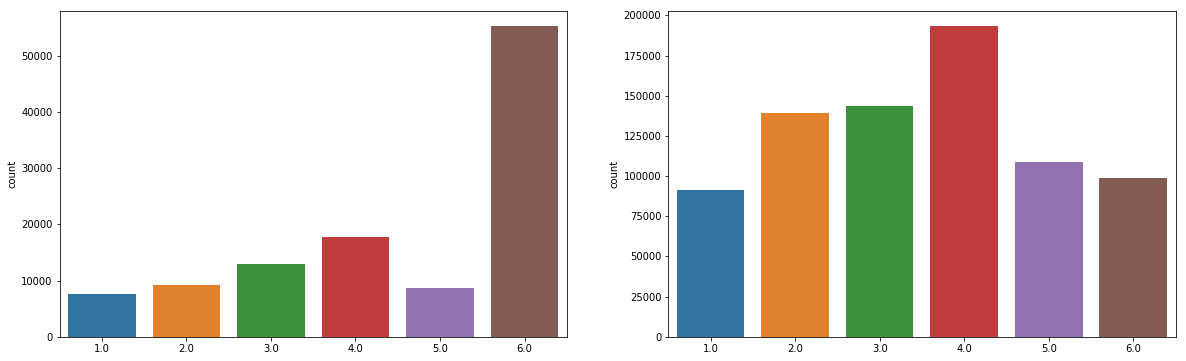

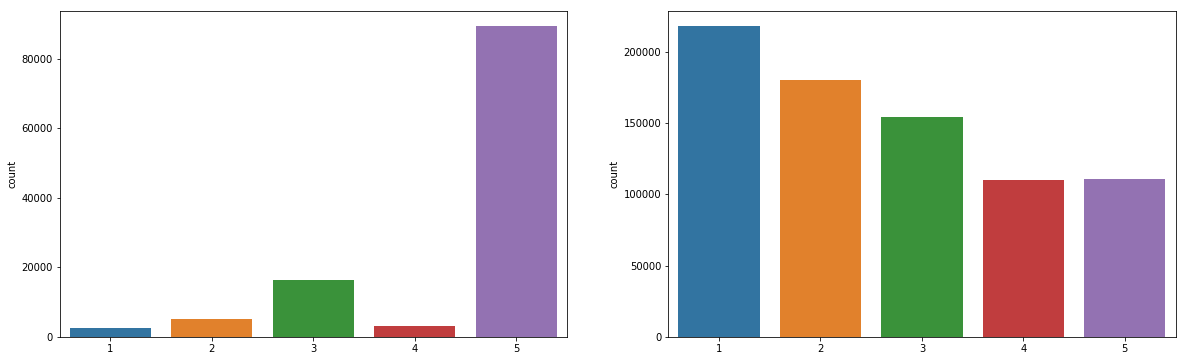

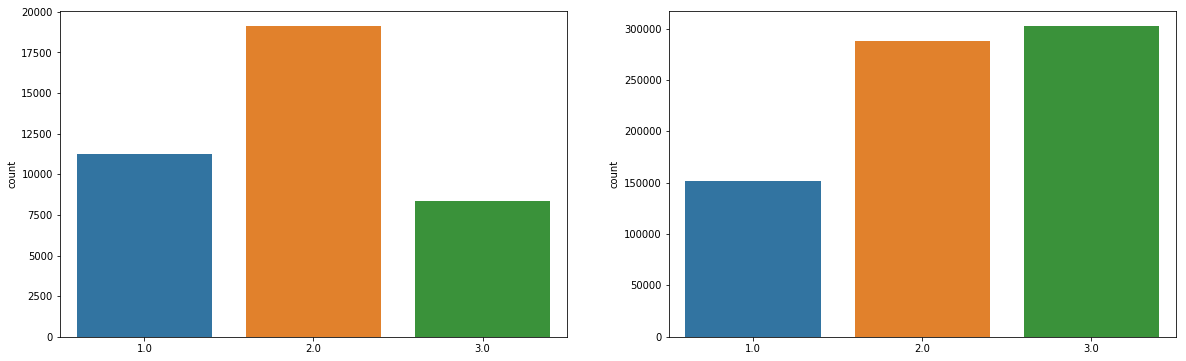

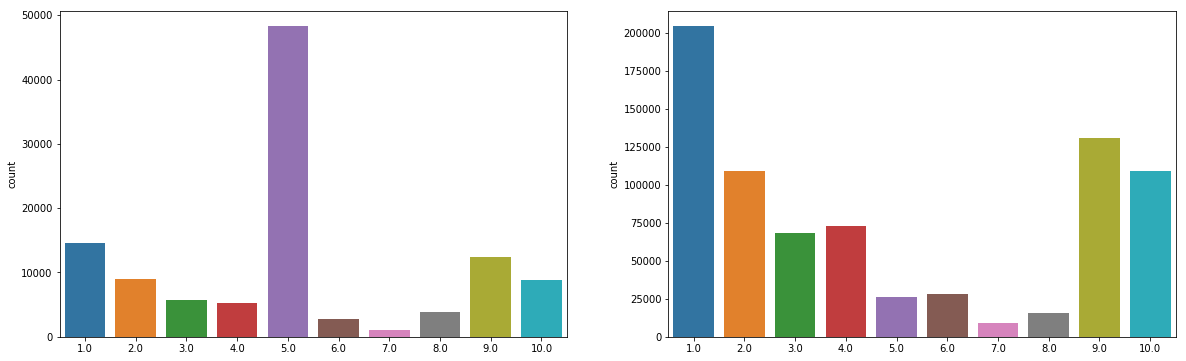

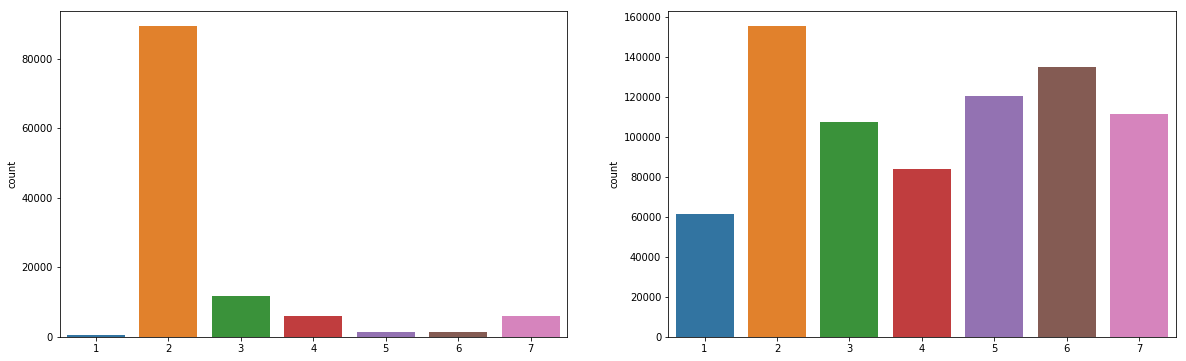

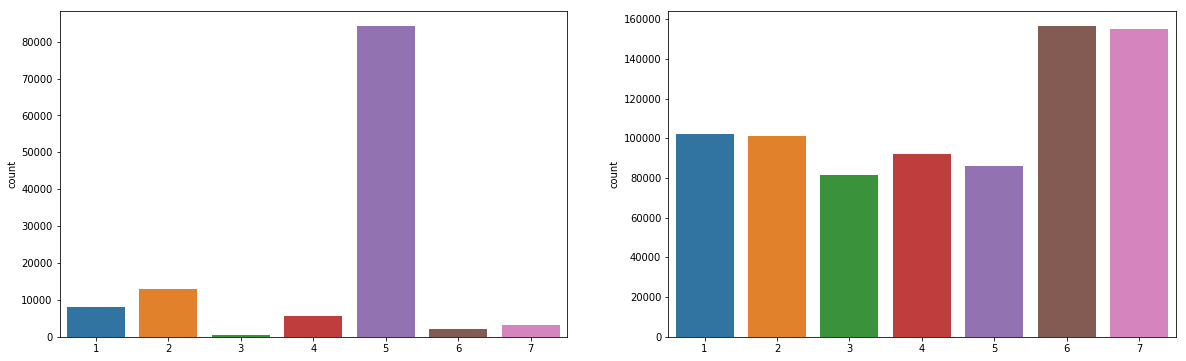

In [18]:
for i in range(2, 30, 5):
    comparison(i)

### Discussion 1.1.3: Assess Missing Data in Each Row
**After investigating the missing values in the data, I found that there is a significant difference to the values after the 10 featur where from 10 to 20 values it appears to me that it may be logical to keep them because they are equal to about 25% of the number of featurs but due to their a few thousand of data which is less than 1% I have I decided to remove them. **
### Are the data with lots of missing values are qualitatively different from data with few or no missing values?<br>
**Yes, there is a difference between data distributions between the two groups for most features.**

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [29]:
# How many features are there of each data type?
# Lists to save values
categorical = []
ordinal = []
mixed = []
numeric = []
interval = []
for ra in feat_info['attribute'].values: # For values in attribute in features info
    for ran in az_out.columns.values: # Column in our cleaned dataset
        if ra in ran: # To check if value exist in our dataset
            fe_typ = feat_info['type'].values[feat_info['attribute'].values == ra ] 
            if fe_typ == 'categorical': # To check types
                categorical.append(ra) # To save coulmns in lists
            if fe_typ == 'ordinal':
                ordinal.append(ra)
            if fe_typ == 'mixed':
                mixed.append(ra)
            if fe_typ == 'numeric':
                numeric.append(ra)
            if fe_typ == 'interval':
                interval.append(ra)    
print('categorical', len(categorical)) # Print the counter
print('ordinal', len(ordinal))
print('mixed', len(mixed))
print('numeric', len(numeric))
print('interval', len(interval))


categorical 19
ordinal 49
mixed 6
numeric 6
interval 0


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [30]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
re_encod_dig=[] # To save in lists re_encod values
re_encod_ch=[]
binary_dig=[]
binary_ch=[]

for rwr in categorical:
    ko = az_out[rwr].value_counts().index.values[0]
    so = az_out[rwr].value_counts().count()
    ko = str(ko)
    p = re.compile('\d+(\.\d)')
    if p.match(ko) or ko.isdigit():
        if so == 2: binary_dig.append(rwr)
        else: re_encod_dig.append(rwr)
    else :
        if so == 2: binary_ch.append(rwr)
        else : re_encod_ch.append(rwr)

In [31]:

print('Multi characters\n',re_encod_ch,'\nMulti digts\n',re_encod_dig,'\nBinary characters\n' , binary_ch,'\nBinary digts\n' ,binary_dig)

Multi characters
 ['CAMEO_DEU_2015'] 
Multi digts
 ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015'] 
Binary characters
 ['OST_WEST_KZ'] 
Binary digts
 ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP']


In [32]:
re_enc = []
for rwr in categorical:
    ko = az_out[rwr].value_counts().index.values[0]
    so = az_out[rwr].value_counts().count()
    ko = str(ko)
    p = re.compile('\d+(\.\d)')
    if p.match(ko) or ko.isdigit():
        if so != 2: 
            re_enc.append(rwr)
    else :
        re_enc.append(rwr)

In [33]:
re_enc = ['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [34]:
# Re-encode categorical variable(s) to be kept in the analysis.
az_grp2_encoded = pd.get_dummies(az_grp2, columns=re_enc)
az_grp2_encoded.shape

(774743, 195)

#### Discussion 1.2.1: Re-Encode Categorical Features

##### Which ones did you keep, which did you drop, and what engineering steps did you perform??<br>
**For summraies of the steps that I did above:**
1. I have created 4 lists for each data type.
2. I have worked with categorical type and createed 4 lists for each categorical type (multi and binary characters, multi and binary digts).
3. I have create dummy variables for (multi and binary characters, and multi digts).

These **featurs have changed to dummy variables** =CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [35]:
# Copy PRAEGENDE_JUGENDJAHRE to two new features
az_grp2_encoded['PRAEGENDE_JUGENDJAHRE_dec'] = az_grp2_encoded['PRAEGENDE_JUGENDJAHRE']
az_grp2_encoded['PRAEGENDE_JUGENDJAHRE_mov'] = az_grp2_encoded['PRAEGENDE_JUGENDJAHRE']

In [36]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer decide.

az_dec = az_grp2_encoded['PRAEGENDE_JUGENDJAHRE_dec'].value_counts()
for r in range(az_dec.shape[0]):
    az_dec_val = az_dec.index[r]
    if az_dec_val == 1 or az_dec_val == 2:
        az_grp2_encoded['PRAEGENDE_JUGENDJAHRE_dec'] = az_grp2_encoded['PRAEGENDE_JUGENDJAHRE_dec'].replace(az_dec_val,-6)
    if az_dec_val == 3 or az_dec_val == 4:
        az_grp2_encoded['PRAEGENDE_JUGENDJAHRE_dec'] = az_grp2_encoded['PRAEGENDE_JUGENDJAHRE_dec'].replace(az_dec_val,-5)
    if az_dec_val == 5 or az_dec_val == 6 or az_dec_val == 7:
        az_grp2_encoded['PRAEGENDE_JUGENDJAHRE_dec'] = az_grp2_encoded['PRAEGENDE_JUGENDJAHRE_dec'].replace(az_dec_val,-4)
    if az_dec_val == 8 or az_dec_val == 9:
        az_grp2_encoded['PRAEGENDE_JUGENDJAHRE_dec'] = az_grp2_encoded['PRAEGENDE_JUGENDJAHRE_dec'].replace(az_dec_val,-3)
    if az_dec_val == 10 or az_dec_val == 11 or az_dec_val == 12 or az_dec_val == 13:
        az_grp2_encoded['PRAEGENDE_JUGENDJAHRE_dec'] = az_grp2_encoded['PRAEGENDE_JUGENDJAHRE_dec'].replace(az_dec_val,-2)
    if az_dec_val == 14 or az_dec_val == 15:
        az_grp2_encoded['PRAEGENDE_JUGENDJAHRE_dec'] = az_grp2_encoded['PRAEGENDE_JUGENDJAHRE_dec'].replace(az_dec_val,-1)

In [37]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer movment.

az_dec = az_grp2_encoded['PRAEGENDE_JUGENDJAHRE_mov'].value_counts()

main = [1,3,5,8,10,12,14]
for r in range(az_dec.shape[0]):
    az_dec_val = az_dec.index[r]
    for m in main:
        if az_dec_val == m :
            az_grp2_encoded['PRAEGENDE_JUGENDJAHRE_mov'] = az_grp2_encoded['PRAEGENDE_JUGENDJAHRE_mov'].replace(az_dec_val,0)
        else : az_grp2_encoded['PRAEGENDE_JUGENDJAHRE_mov'] = az_grp2_encoded['PRAEGENDE_JUGENDJAHRE_mov'].replace(az_dec_val,-1)

In [38]:
az_grp2_encoded.shape

(774743, 197)

In [39]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# Copy CAMEO_INTL_2015 to two new features

az_grp2_encoded['CAMEO_INTL_2015_Wealth'] = az_grp2_encoded['CAMEO_INTL_2015']
az_grp2_encoded['CAMEO_INTL_2015_Typology'] = az_grp2_encoded['CAMEO_INTL_2015']

In [40]:
# Engineer new CAMEO_INTL_2015_Wealth feature.

az_wel = az_grp2_encoded['CAMEO_INTL_2015_Wealth'].value_counts()
for r in range(az_wel.shape[0]):
    az_dec_val = az_wel.index[r]    
    wal = int(az_dec_val)//10
    az_grp2_encoded['CAMEO_INTL_2015_Wealth'] = az_grp2_encoded['CAMEO_INTL_2015_Wealth'].replace(az_dec_val,wal) 
az_grp2_encoded['CAMEO_INTL_2015_Wealth'].value_counts()

5.0    220529
4.0    185971
2.0    183247
1.0    115911
3.0     65629
Name: CAMEO_INTL_2015_Wealth, dtype: int64

In [41]:
# Engineer new CAMEO_INTL_2015_Typology feature.

az_wel = az_grp2_encoded['CAMEO_INTL_2015_Typology'].value_counts()
for r in range(az_wel.shape[0]):
    az_dec_val = az_wel.index[r]    
    wal = int(az_dec_val)%10
    az_grp2_encoded['CAMEO_INTL_2015_Typology'] = az_grp2_encoded['CAMEO_INTL_2015_Typology'].replace(az_dec_val,wal) 
az_grp2_encoded['CAMEO_INTL_2015_Typology'].value_counts()

1.0    240237
4.0    226911
3.0    114588
5.0    114421
2.0     75130
Name: CAMEO_INTL_2015_Typology, dtype: int64

In [42]:
az_grp2_encoded.shape

(774743, 199)

In [43]:
# drop coulmns
az_grp2_fin = az_grp2_encoded
az_grp2_fin=az_grp2_fin.drop('PRAEGENDE_JUGENDJAHRE',axis=1)
az_grp2_fin=az_grp2_fin.drop('CAMEO_INTL_2015',axis=1)
az_grp2_fin.shape

(774743, 197)

#### Discussion 1.2.2: Engineer Mixed-Type Features

##### Which ones did you keep, which did you drop, and what engineering steps did you perform?)
I have **engineered** following features which are have a valuable information in our dataset.
1. 'PRAEGENDE_JUGENDJAHRE_dec' for 40 = -6 and for 50 = -5 etc..
2. 'PRAEGENDE_JUGENDJAHRE_mov' I have changed them to 0 and -1
3. for 'CAMEO_INTL_2015_Wealth' and 'CAMEO_INTL_2015_Typology' I have break up the two-digit codes<br>

I have **droped** following features PRAEGENDE_JUGENDJAHRE, CAMEO_INTL_2015 <br>


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [3]:
def clean_data(df):

    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for az_r in range(df.shape[1]): # For to 85
        az_col = df.columns[az_r] #Column value
        mis_cols = feat_info['missing_or_unknown'][az_r] #Missing in each colmun
        mis_len = len(mis_cols)-1 #length of a string without ending
        mis_vals = mis_cols[1:mis_len].split(',') #Missing value sparted by ,
        az_vals = df[az_col].value_counts(dropna=False) #Values in each column
        for mis_val in mis_vals: # To go inside each value in mis value
            if (mis_val.startswith('-') and mis_val[1:].isdigit()) or mis_val.isdigit(): #To avoid charcters
                if int(mis_val) in az_vals: #Change charcters to int to fix the int values
                    df[az_col]=df[az_col].replace(int(mis_val),np.nan) #Replace values to Nan
            else : 
                if mis_val in az_vals or '' in az_vals: #To check about charcters values
                    df[az_col]=df[az_col].replace(mis_val,np.nan) #Replace values to Nan

                    
    # remove selected columns and rows, ...
    drop_cols = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df = df.drop(drop_cols,axis=1)
    Rows_na = df.isnull().sum(axis = 1)
    gruop1 = []
    gruop2 = []
    for i in range(Rows_na.shape[0]):
        if Rows_na[i] >= 10:
            gruop1.append(Rows_na.index[i])
        else :
            gruop2.append(Rows_na.index[i])  
    df1 = df.loc[gruop1]
    df2 = df.loc[gruop2]

    # select, re-encode, and engineer column values.
    re_enc = ['CAMEO_DEU_2015','OST_WEST_KZ', 'CJT_GESAMTTYP',
              'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN',
              'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
              'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP',
              'GEBAEUDETYP', 'CAMEO_DEUG_2015']
    df2 = pd.get_dummies(df2, columns=re_enc)
    
    
    df2['PRAEGENDE_JUGENDJAHRE_dec'] = df2['PRAEGENDE_JUGENDJAHRE']
    df2['PRAEGENDE_JUGENDJAHRE_mov'] = df2['PRAEGENDE_JUGENDJAHRE']
    az_dec = df2['PRAEGENDE_JUGENDJAHRE_dec'].value_counts()
    
    
    for r in range(az_dec.shape[0]):
        az_dec_val = az_dec.index[r]
        if az_dec_val == 1 or az_dec_val == 2:
            df2['PRAEGENDE_JUGENDJAHRE_dec'] = df2['PRAEGENDE_JUGENDJAHRE_dec'].replace(az_dec_val,-6)
        if az_dec_val == 3 or az_dec_val == 4:
            df2['PRAEGENDE_JUGENDJAHRE_dec'] = df2['PRAEGENDE_JUGENDJAHRE_dec'].replace(az_dec_val,-5)
        if az_dec_val == 5 or az_dec_val == 6 or az_dec_val == 7:
            df2['PRAEGENDE_JUGENDJAHRE_dec'] = df2['PRAEGENDE_JUGENDJAHRE_dec'].replace(az_dec_val,-4)
        if az_dec_val == 8 or az_dec_val == 9:
            df2['PRAEGENDE_JUGENDJAHRE_dec'] = df2['PRAEGENDE_JUGENDJAHRE_dec'].replace(az_dec_val,-3)
        if az_dec_val == 10 or az_dec_val == 11 or az_dec_val == 12 or az_dec_val == 13:
            df2['PRAEGENDE_JUGENDJAHRE_dec'] = df2['PRAEGENDE_JUGENDJAHRE_dec'].replace(az_dec_val,-2)
        if az_dec_val == 14 or az_dec_val == 15:
            df2['PRAEGENDE_JUGENDJAHRE_dec'] = df2['PRAEGENDE_JUGENDJAHRE_dec'].replace(az_dec_val,-1)
        
    az_dec = df2['PRAEGENDE_JUGENDJAHRE_mov'].value_counts()
    main = [1,3,5,8,10,12,14]
    for r in range(az_dec.shape[0]):
        az_dec_val = az_dec.index[r]
        for m in main:
            if az_dec_val == m :
                df2['PRAEGENDE_JUGENDJAHRE_mov'] = df2['PRAEGENDE_JUGENDJAHRE_mov'].replace(az_dec_val,0)
            else :
                df2['PRAEGENDE_JUGENDJAHRE_mov'] = df2['PRAEGENDE_JUGENDJAHRE_mov'].replace(az_dec_val,-1)
    
    df2['CAMEO_INTL_2015_Wealth'] = df2['CAMEO_INTL_2015']
    df2['CAMEO_INTL_2015_Typology'] = df2['CAMEO_INTL_2015']
    
    az_wel = df2['CAMEO_INTL_2015_Wealth'].value_counts()
    for r in range(az_wel.shape[0]):
        az_dec_val = az_wel.index[r]    
        wal = int(az_dec_val)//10
        df2['CAMEO_INTL_2015_Wealth'] = df2['CAMEO_INTL_2015_Wealth'].replace(az_dec_val,wal)
        
    az_wel = df2['CAMEO_INTL_2015_Typology'].value_counts()
    for r in range(az_wel.shape[0]):
        az_dec_val = az_wel.index[r]    
        wal = int(az_dec_val)%10
        df2['CAMEO_INTL_2015_Typology'] = df2['CAMEO_INTL_2015_Typology'].replace(az_dec_val,wal)
    
    df2= df2.drop('PRAEGENDE_JUGENDJAHRE',axis=1)
    df2= df2.drop('CAMEO_INTL_2015',axis=1)
    

    # Return the cleaned dataframe.
    
    return df2

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values before applying your scaler. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [70]:
# Perform feature trimming, re-encoding, and engineering for demographics data

az_grp2_fin = clean_data(azdias)

In [71]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

imp = Imputer(strategy='most_frequent')
az_grp2_imp = imp.fit_transform(az_grp2_fin)


In [72]:
# Apply feature scaling to the general population demographics data.
scl = StandardScaler()
az_grp2_scal = scl.fit_transform(az_grp2_imp)


In [7]:
# Create a dataframe for imputed and scaled dataset
az_grp2 = pd.DataFrame(az_grp2_scal, columns = az_grp2_fin.columns)


### Discussion 2.1: Apply Feature Scaling

#### reporting your decisions regarding feature scaling

After engineering of demographics data and see the what we did to dealing with categorical columns I have decide to **impute using strategy='most frequent'** also do we have a small missing values less than 10, and for scaling I choose **StandardScaler** <br><br>
I have did the imputation first before scaling do you the scaling will not work with nan values


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [79]:
# Creates a scree plot associated with the principal components
#  Function for visualization the Function

def scree_plot(pca):
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

In [8]:
#Transforms data using PCA to create n_components, and provides back the results of the transformation.

# Function for using PCA

def do_pca(n_components, data):
    pca = PCA(n_components)
    X_pca = pca.fit_transform(data)
    return pca, X_pca

In [9]:
# Apply PCA to the data.
pca, X_pca = do_pca(None, az_grp2)


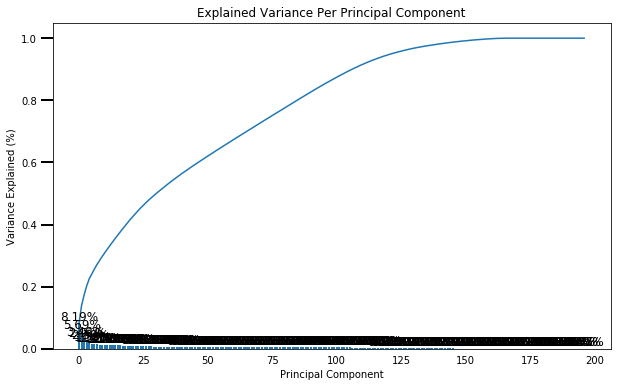

In [80]:
# use the scree_plot function take a closer look at the results of pca analysis
scree_plot(pca)

In [47]:
# Refelect variance ratios
dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
components = pd.DataFrame(np.round(pca.components_, 4), columns = az_grp2.keys())
ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
variance_ratios.index = dimensions


In [66]:
# Check which is the dimension where the delta is small as 1.2.

q =0
for i in range(variance_ratios['Explained Variance'].shape[0]):
    q = (variance_ratios['Explained Variance'][i]*100)
    print(q)
    if q <=1.2:
        print("The {} , is explain less than 1.2 of our data.".format(variance_ratios['Explained Variance'].index[i]))
        break


8.19
5.6899999999999995
3.46
2.92
2.3
1.59
1.53
1.47
1.31
1.25
1.1900000000000002
The Dimension 11 , is explain less than 1.2 of our data.


In [61]:
# Check which is the dimension where the delta is so small as 0.1.

q =0
for i in range(variance_ratios['Explained Variance'].shape[0]):
    q = (variance_ratios['Explained Variance'][i]*100)
    if q <=0.1:
        print("The {} , is explain less than 0.1 of our data.".format(variance_ratios['Explained Variance'].index[i]))
        break

The Dimension 146 , is explain less than 0.1 of our data.


In [64]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca, az_pca = do_pca(11, az_grp2)


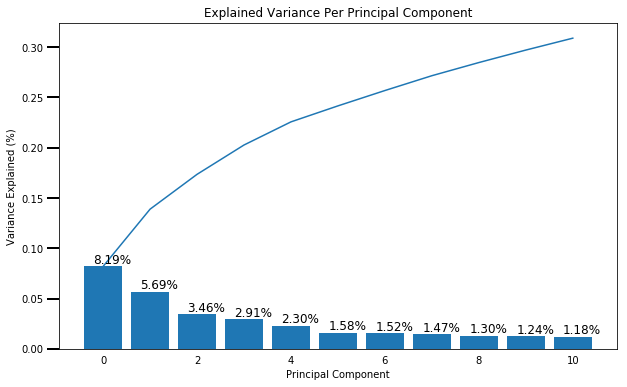

In [114]:
scree_plot(pca)

### Discussion 2.2: Perform Dimensionality Reduction

##### How many principal components / transformed features are you retaining for the next step of the analysis?) 

After investigation the increase in variance in order to come up with a point where the delta is small as 1.2 that we should not invest more computational power and time, I found by using 11 components the increase in variance will be 1.19. And to come up with the very small delta as 0.1 we need to 146 which is a huge number of components to deal with. And for previous reasons I decided to use 11 components.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [183]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pcaWfeat = pd.DataFrame(np.round(pca.components_, 4), columns = az_grp2.keys())
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def interpret_feature(i):
    # Sort columns from least to greatest based on PCA result
    df_sort = pcaWfeat.columns[pcaWfeat.iloc[i].argsort()]
    # Reverse the columns to our lest
    df_sort1 = pcaWfeat[df_sort]
    # Print first and last columns values
    for comp in range(5):
        col_p = 196 - comp
        col_n = 0 + comp
        print("positve {} ,  negative {}.".format(df_sort1.columns[col_p],df_sort1.columns[col_n])) 
interpret_feature(0)

positve LP_STATUS_GROB_1.0 ,  negative MOBI_REGIO.
positve PLZ8_ANTG3 ,  negative PLZ8_ANTG1.
positve CAMEO_INTL_2015_Wealth ,  negative FINANZ_MINIMALIST.
positve HH_EINKOMMEN_SCORE ,  negative KBA05_ANTG1.
positve PLZ8_ANTG4 ,  negative KBA05_GBZ.


In [181]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
interpret_feature(1)

positve ALTERSKATEGORIE_GROB ,  negative PRAEGENDE_JUGENDJAHRE_dec.
positve FINANZ_VORSORGER ,  negative FINANZ_SPARER.
positve ZABEOTYP_3 ,  negative SEMIO_REL.
positve SEMIO_ERL ,  negative FINANZ_UNAUFFAELLIGER.
positve SEMIO_LUST ,  negative SEMIO_PFLICHT.


In [182]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
interpret_feature(2)

positve SEMIO_VERT ,  negative ANREDE_KZ.
positve SEMIO_FAM ,  negative SEMIO_KAEM.
positve SEMIO_SOZ ,  negative SEMIO_DOM.
positve SEMIO_KULT ,  negative SEMIO_KRIT.
positve FINANZTYP_5 ,  negative SEMIO_ERL.


### Discussion 2.3: Interpret Principal Components

##### Can we interpret positive and negative values from them in a meaningful way?
After investigation each value level and their meaning, I have created following table that will help to explain what I found. We can see following observations:
*  In each components the positive feature is shown information that is similar the information that show in negative value..
* In first component is have form most of data levels like for positive (1. social status, 2. 6-10 family houses, 3. wealth, 4. household net income, 5. 10 family houses).
* In second and third components are showing features that from person level which show the powerful of these features in our dataset.

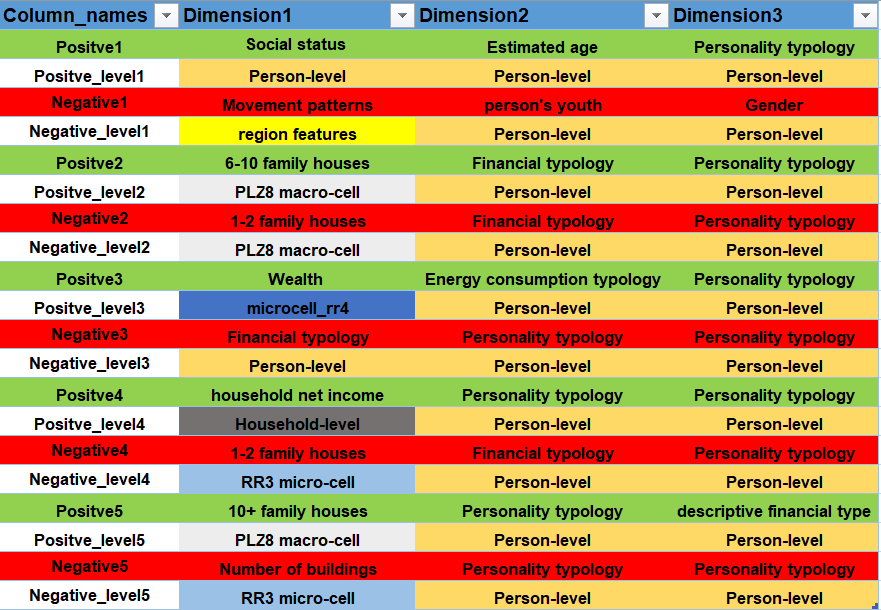

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [11]:
# Over a number of different cluster counts...
def get_kmeans_score(data, center):
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

scores = []
possible_k_values = range(2, 30, 4)
for center in possible_k_values:
    # run k-means clustering on the data and compute the average within-cluster distances.
    scores.append(get_kmeans_score(az_pca, center))
    print(center)

2
6
10
14
18
22
26


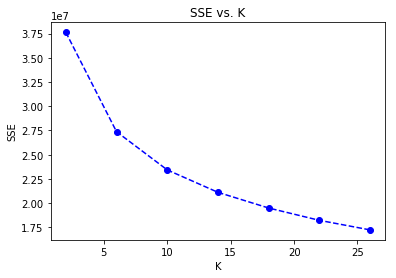

In [12]:
plt.plot(possible_k_values, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [16]:
# Investigated again between 11 to 16 
new_k_values = range(11, 17, 1)

new_scores = []

for center in new_k_values:
    new_scores.append(get_kmeans_score(az_pca, center))
    print(center)

11
12
13
14
15
16


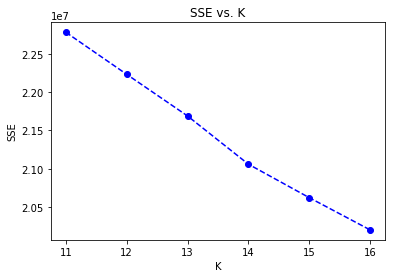

In [17]:
plt.plot(new_k_values, new_scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [65]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=14)
az_clus = kmeans.fit_predict(az_pca)


### Discussion 3.1: Apply Clustering to General Population

##### Into how many clusters have you decided to segment the population?)

After investigation in clusters between 2 until 30, I found we have the big decreasing steps for average was between 3 to 16. And since we need to make the clusters between 10 and 30, I have investigated again between 11 to 16 and I found in 14 was the best decreased.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [67]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',delimiter=';')
customers = clean_data(customers)
customers['GEBAEUDETYP_5.0'] = 0

In [68]:
# Checking columns are not exict in customers dataset
for ran in az_grp2.columns.values:
    if ran not in customers.columns.values:
        print(ran)

In [24]:
# Create missing columns with 0 values
customers['GEBAEUDETYP_5.0'] = 0

In [73]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_imp = imp.transform(customers)
customers_scal = scl.transform(customers_imp)
customers = pd.DataFrame(customers_scal, columns = customers.columns)


In [74]:
# Apply pca and kemeans
customers_pca = pca.transform(customers)
customers_clus = kmeans.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [75]:
# Add segment to general population dataset
az_clu = az_grp2_fin
az_clu['segment'] = az_clus

In [76]:
# Add segment to customers dataset

customers1 = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',delimiter=';')
customers1 = clean_data(customers1)
customers1['GEBAEUDETYP_5.0'] = 0
customers_clu = customers1
customers_clu['segment'] = customers_clus

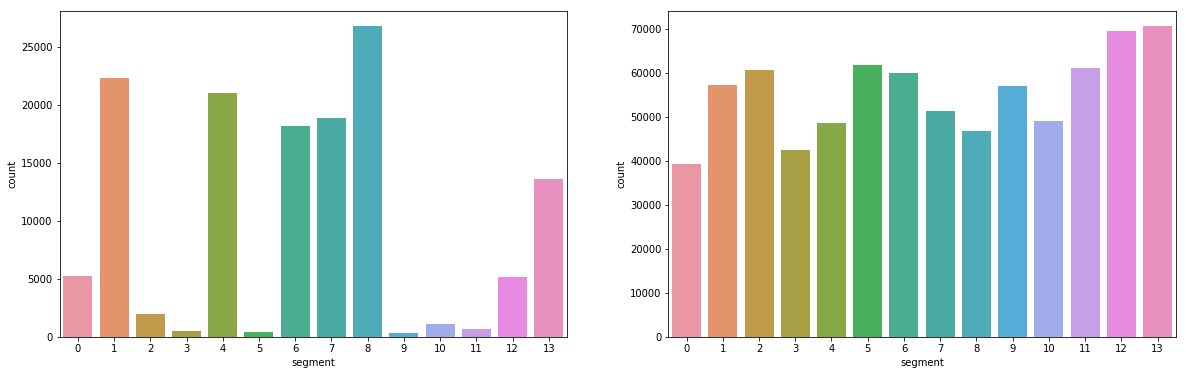

In [77]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
fig, ax = plt.subplots(1,2,figsize=(20, 6))
sns.countplot(customers_clu['segment'],ax = ax[0])
sns.countplot(az_clu['segment'],ax = ax[1])

In [90]:
# Function to compared between overrepresented cluster in both datasets
def comparison_culsters(col):
    # The most common segment in Customers dataset which are segment = 1 in order to compare with Genral
    cust_1 = customers_clu[col][customers_clu['segment'] == 1]
    # The most common segment in Genral dataset which are segment = 5 to compare with Customers
    az_1 = az_clu[col][az_clu['segment'] == 5]
    fig, ax = plt.subplots(1,2,figsize=(20, 6))
    sns.countplot(cust_1,ax = ax[0])
    sns.countplot(az_1,ax = ax[1])

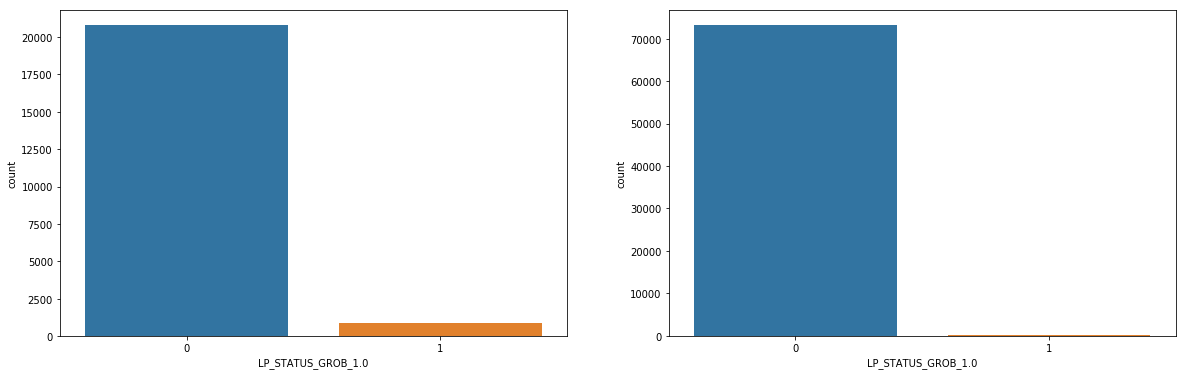

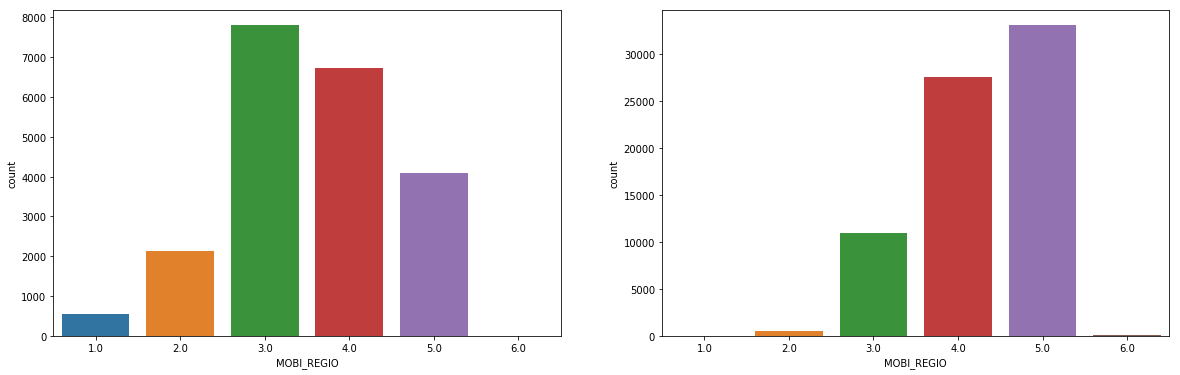

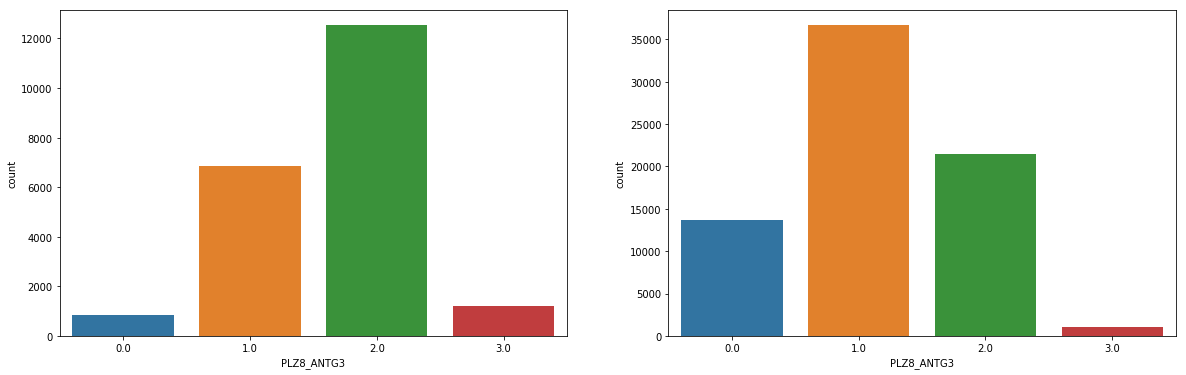

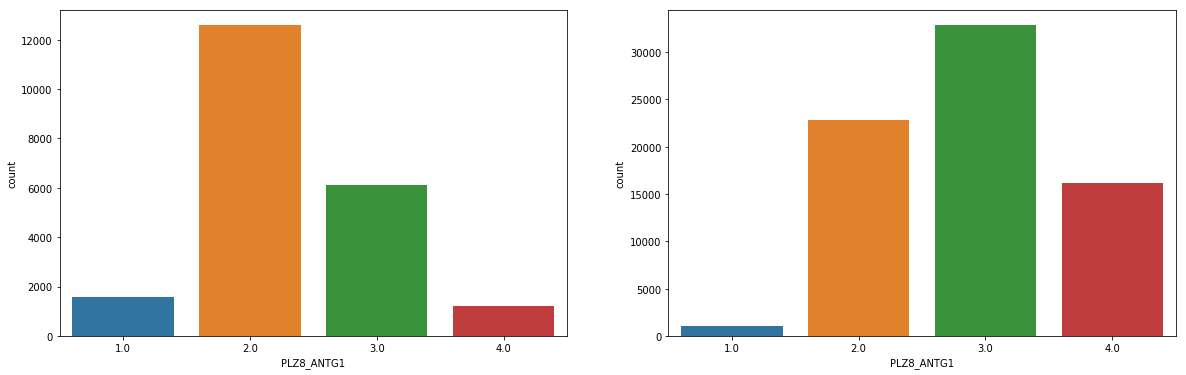

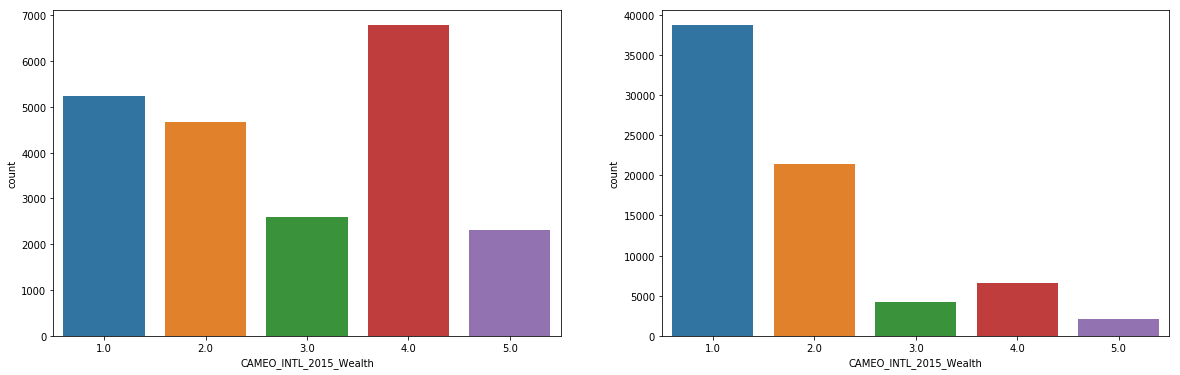

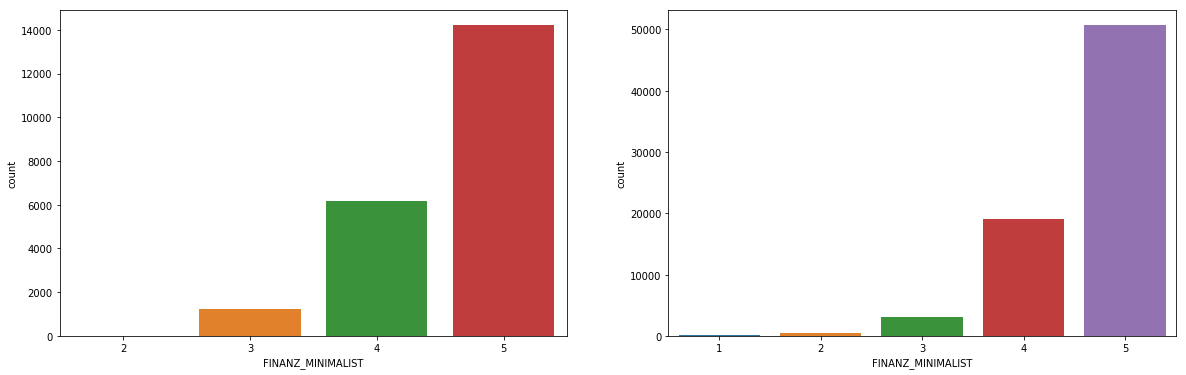

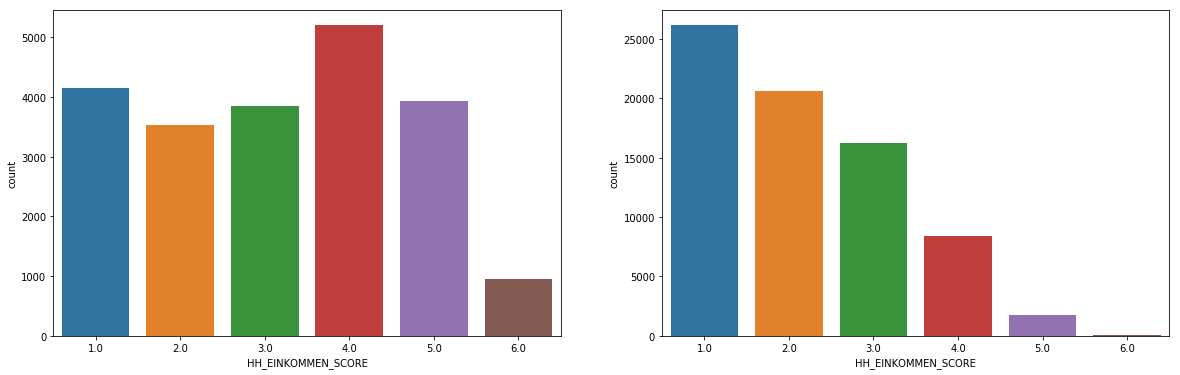

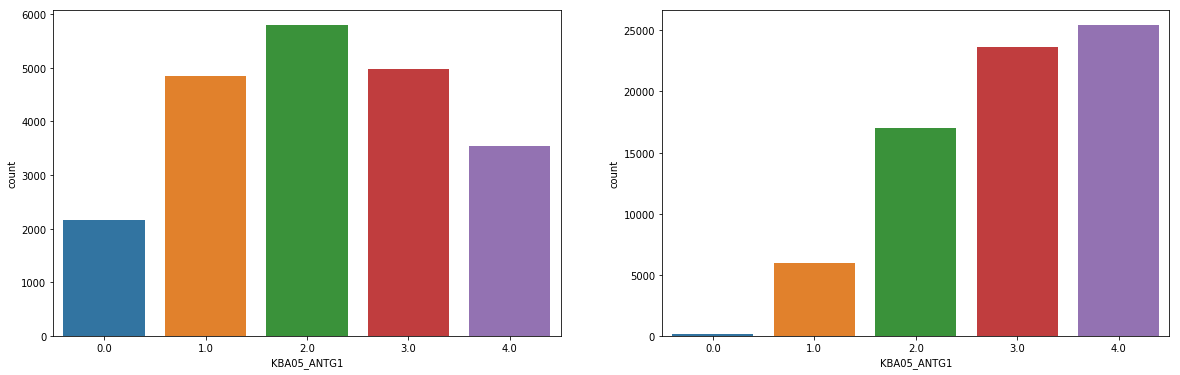

In [91]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
# Features in first components from our PCA analsys 
featurs = ['LP_STATUS_GROB_1.0' ,  'MOBI_REGIO' , 'PLZ8_ANTG3' ,  'PLZ8_ANTG1',
           'CAMEO_INTL_2015_Wealth' ,  'FINANZ_MINIMALIST', 'HH_EINKOMMEN_SCORE' , 'KBA05_ANTG1']

for feat in featurs:
    comparison_culsters(feat)

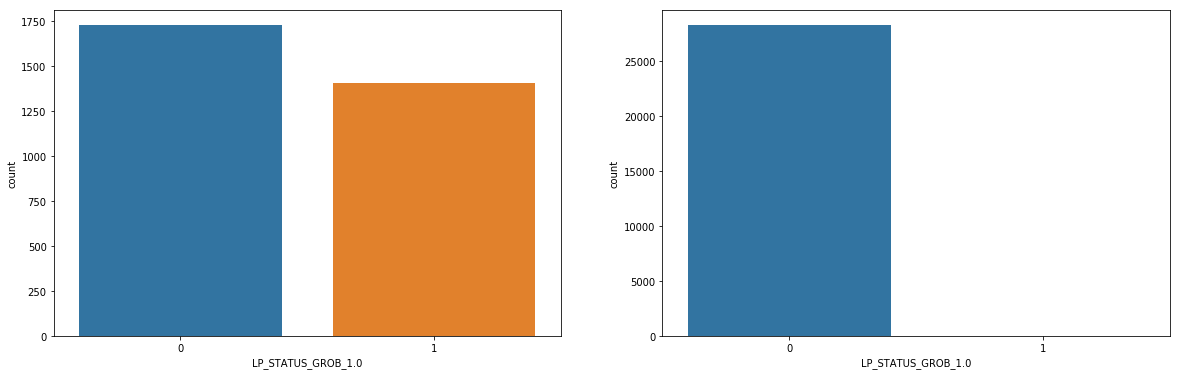

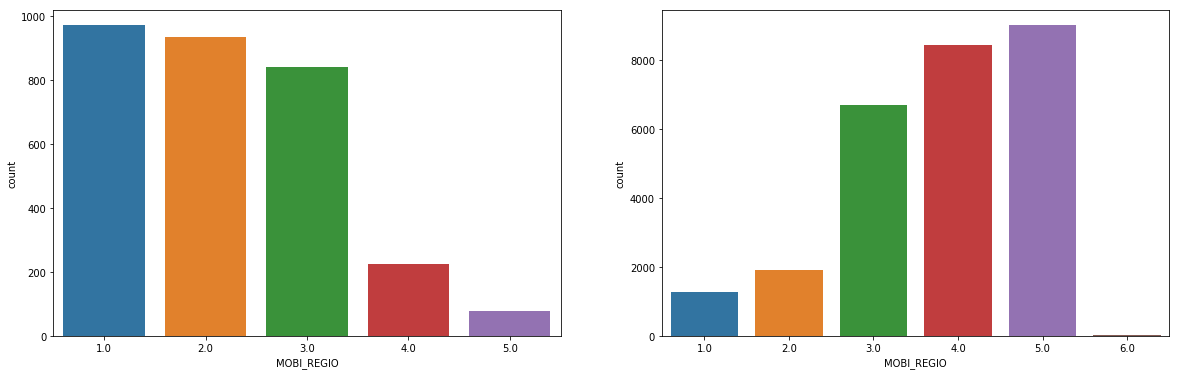

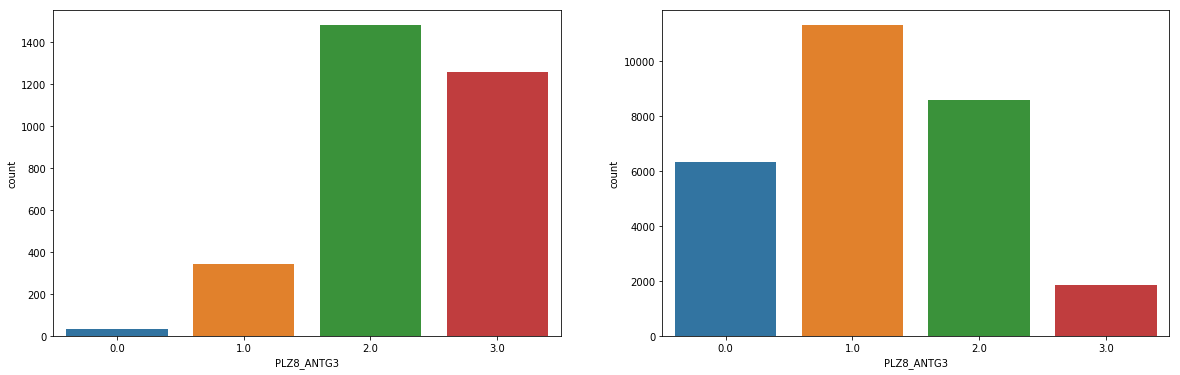

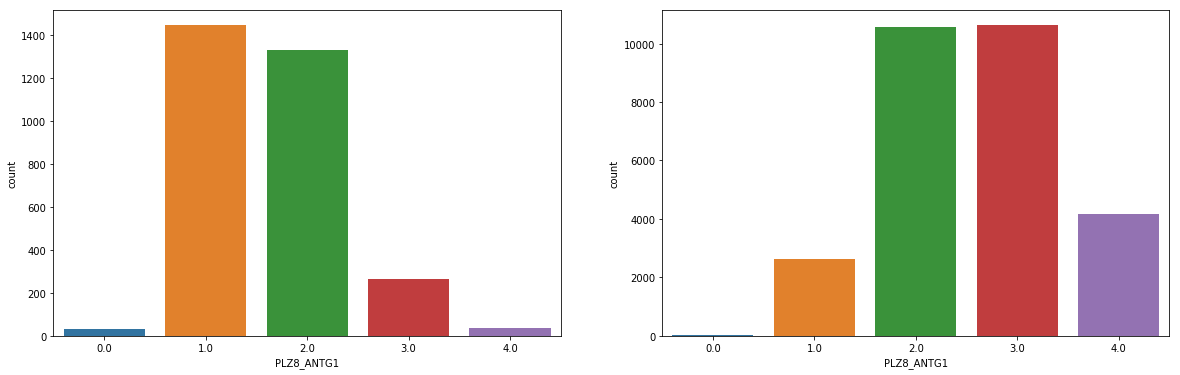

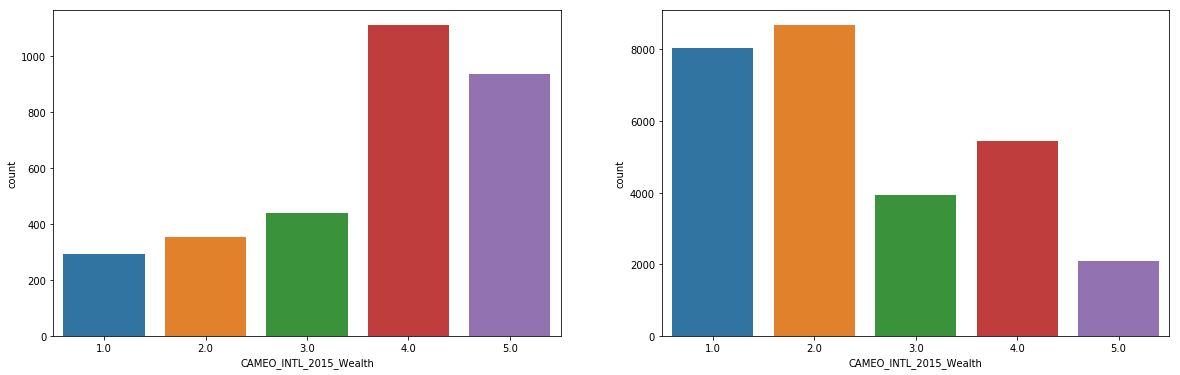

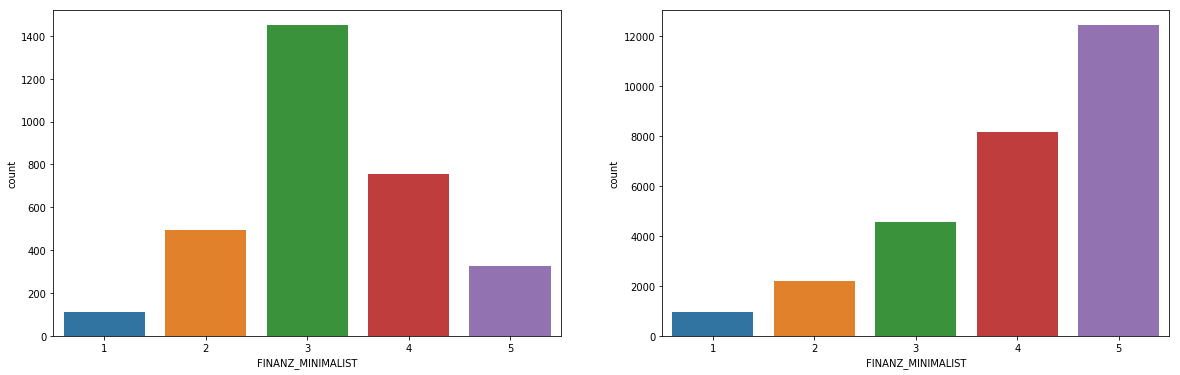

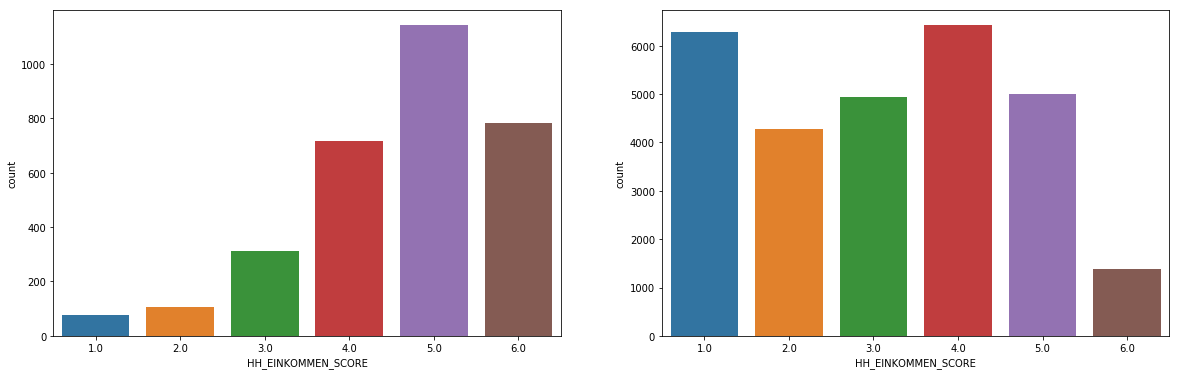

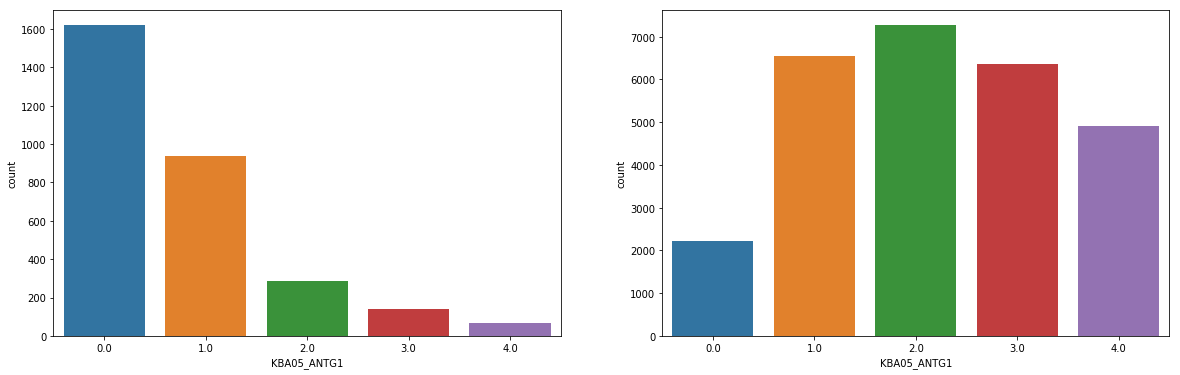

In [92]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
def comparison_culsters_under(col):
    
# The least common segment in Customers dataset which are segment = 8 in order to compare with Genral
    cust_1 = customers_clu[col][customers_clu['segment'] == 8]
    
# The least common segment in Genral dataset which are segment = 13 in order to compare with Customers
    az_1 = az_clu[col][az_clu['segment'] == 13]
    fig, ax = plt.subplots(1,2,figsize=(20, 6))
    sns.countplot(cust_1,ax = ax[0])
    sns.countplot(az_1,ax = ax[1])
    
# Features in first components from our PCA analsys 
featurs = ['LP_STATUS_GROB_1.0' ,  'MOBI_REGIO' , 'PLZ8_ANTG3' ,  'PLZ8_ANTG1',
           'CAMEO_INTL_2015_Wealth' ,  'FINANZ_MINIMALIST', 'HH_EINKOMMEN_SCORE' , 'KBA05_ANTG1']
for feat in featurs:
    comparison_culsters_under(feat)


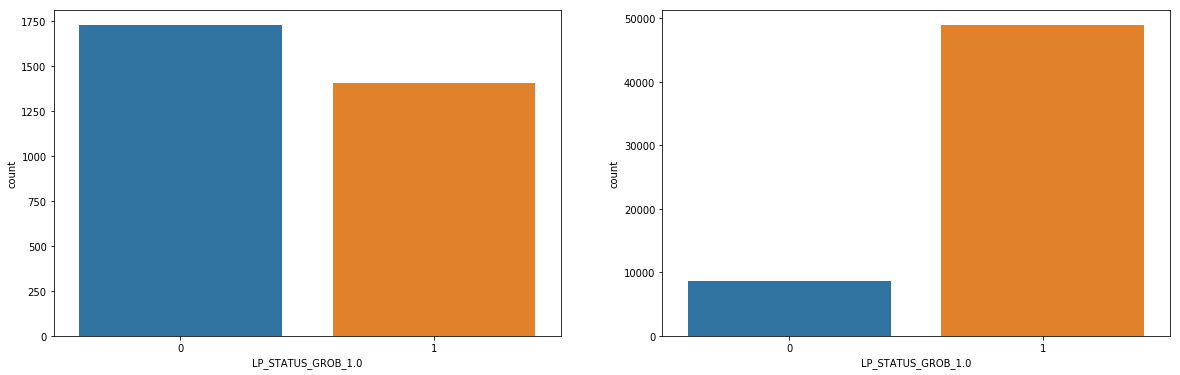

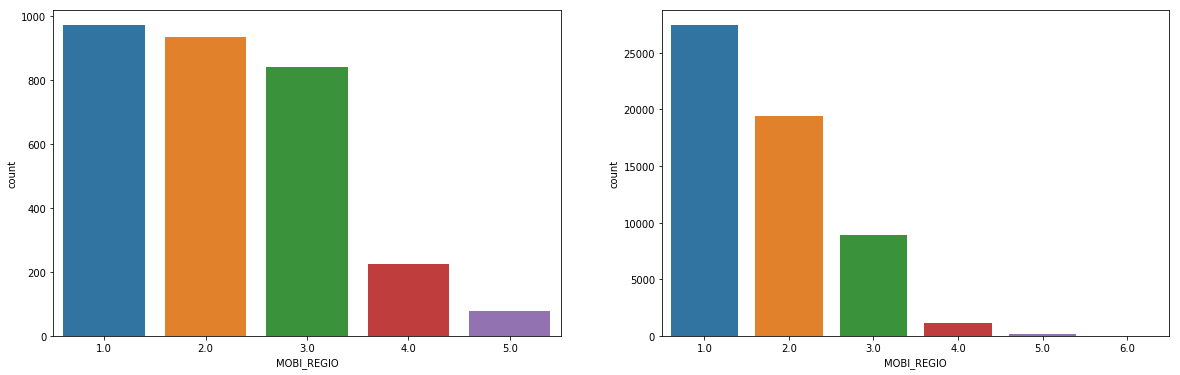

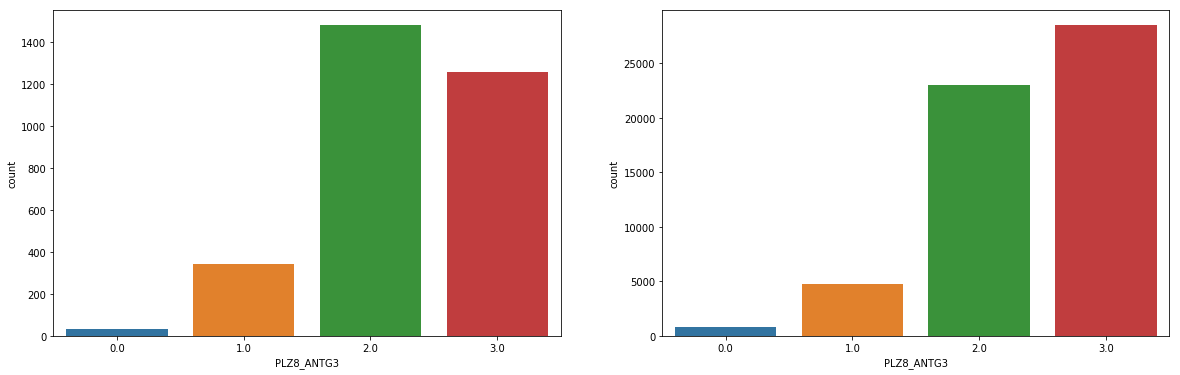

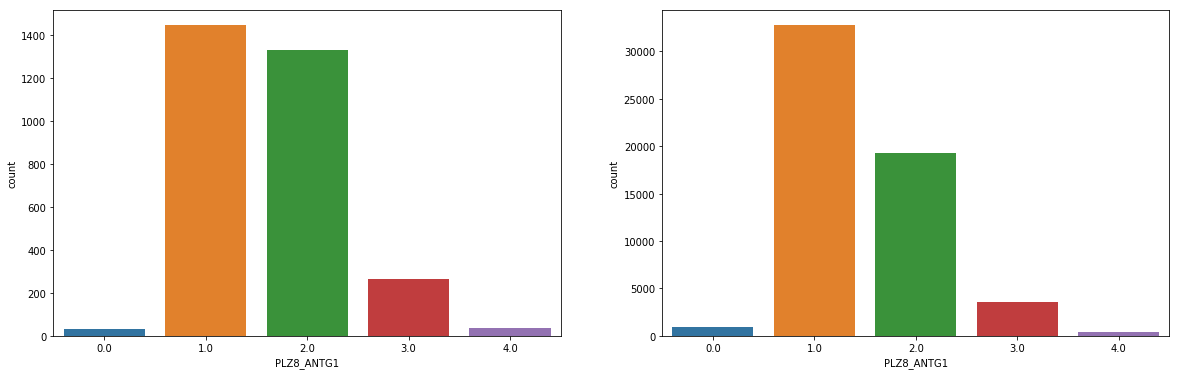

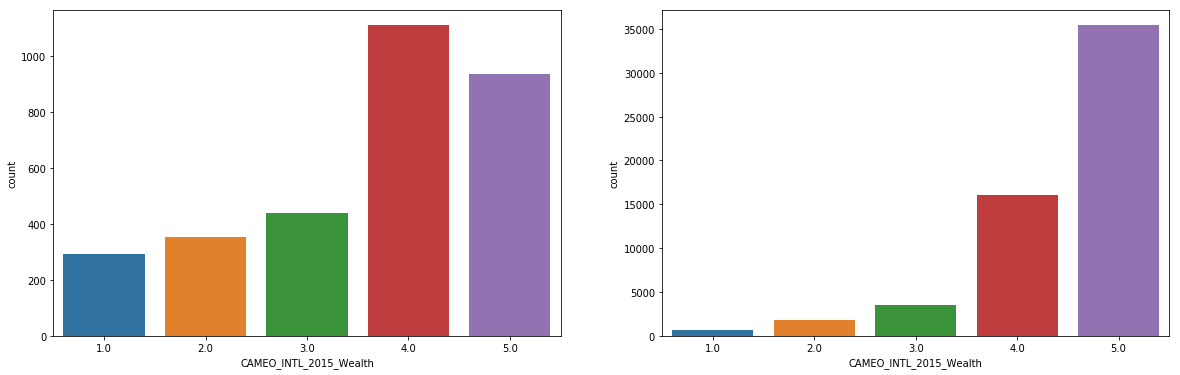

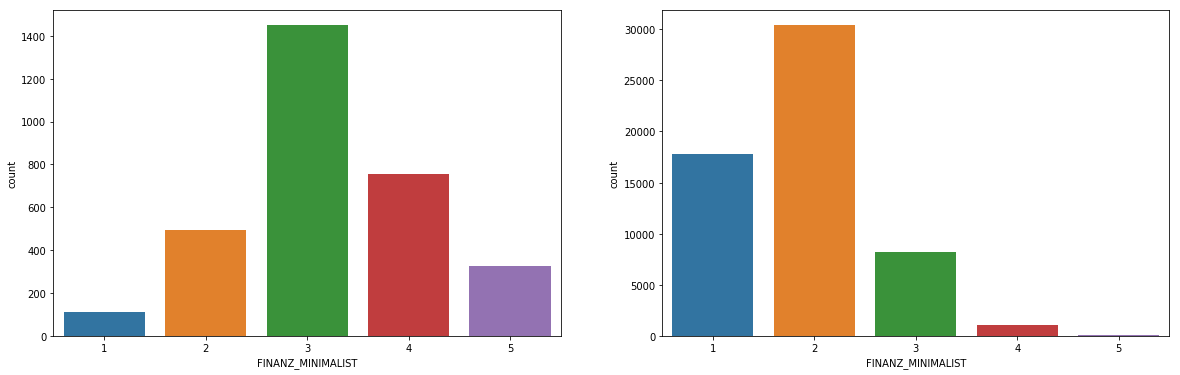

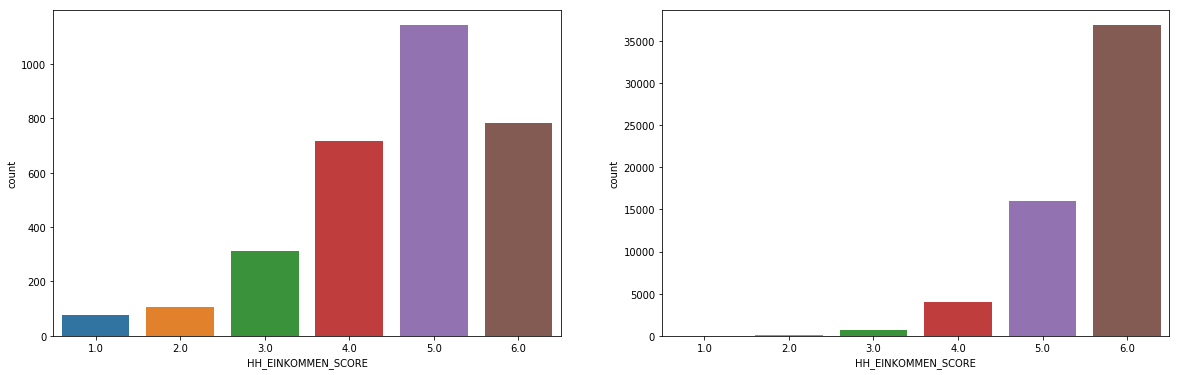

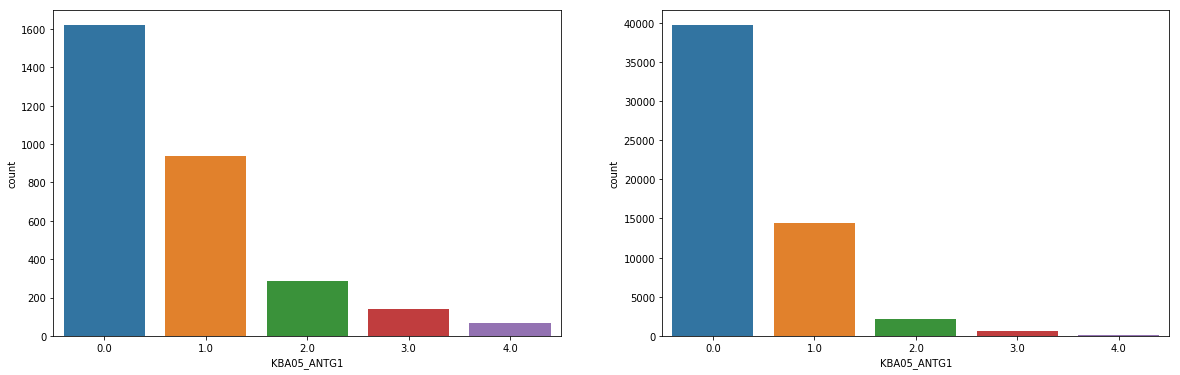

In [97]:
def comparison_culsters_same(col):
    # Same segment
    cust_1 = customers_clu[col][customers_clu['segment'] == 8]
    az_1 = az_clu[col][az_clu['segment'] == 8]
    fig, ax = plt.subplots(1,2,figsize=(20, 6))
    sns.countplot(cust_1,ax = ax[0])
    sns.countplot(az_1,ax = ax[1])

# Features in first components from our PCA analsys 
featurs = ['LP_STATUS_GROB_1.0' ,  'MOBI_REGIO' , 'PLZ8_ANTG3' ,  'PLZ8_ANTG1',
           'CAMEO_INTL_2015_Wealth' ,  'FINANZ_MINIMALIST', 'HH_EINKOMMEN_SCORE' , 'KBA05_ANTG1']
for feat in featurs:
    comparison_culsters_same(feat)

### Discussion 3.3: Compare Customer Data to Demographics Data

##### Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

**After comparing the segments between Customer Data to Demographics Data, I found following:**<br><br>
1.The segment most represented in the Customer Data is segment 1, which is classified as a segment with a high presence of the Demographics Data segments as well.<br><br>
2.The lowest segment of Customer Data is segment 8, which is classified as having a high presence of the Demographics Data segments, which is worth to considering.<br>
<br> **After comparing the features the most important from our PCA analysis, between the most popular segments in Demographics Data segments 5 and the Customer Data segments 1, I found the following:**<br><br>
1.For the feature Social status both segments 1 and 5 are not low-income earners.<br><br>
2.For the feature Movement patterns for the segment 1 the most represented in the Customer Data are Middle Movement, which are classified as a few on the Demographics Data segment 5. But for the feature the most represented in the Demographics Data segment 5 is Very-low Movement, which are classified as a average in the Customer Data segment 1.<br><br>
3.For the feature Number of 6-10 family for the segment 1 the most represented in the Customer Data are Average Share, which are classified as a average on the Demographics Data segment 5. But for the feature the most represented in the Demographics Data segment 5 is Lower Share, which are classified as a average in the Customer Data segment 1.<br><br>
4.For the feature Wealth for the segment 1 the most represented in the Customer Data are Less-Affluent Households, which are classified as a low on the Demographics Data segment 5. But for the feature the most represented in the Demographics Data segment 5 is Wealthy Households, which are classified as a average in the Customer Data segment 1.<br><br>

<br> **And when comparing the features the most important from our PCA analysis, between the least common segments in Demographics Data segments 13 and the Customer Data segments 8, I found the following:**<br><br>
1.For the feature Social status for segment 8 I found some of them are low-income earners and some of them are not low-income earners and for 13 they are not low-income earners.<br><br>
2.For the feature Movement patterns for the segment 8 the most represented in the Customer Data are Very-high Movement, which are classified as a few on the Demographics Data segment 13. But for the feature the most represented in the Demographics Data segment 13 is Very-low Movement, which are classified as a few in the Customer Data segment 8.<br><br>
3.For the feature Number of 6-10 family for the segment 8 the most represented in the Customer Data are Average Share, which are classified as a average on the Demographics Data segment 13. But for the feature the most represented in the Demographics Data segment 13 is Lower Share, which are classified as a few in the Customer Data segment 8.<br><br>
4.For the feature Wealth for the segment 8 the most represented in the Customer Data are Less-Affluent Households, which are classified as a average on the Demographics Data segment 13. But for the feature the most represented in the Demographics Data segment 13 is Prosperous Households, which are classified as a few in the Customer Data segment 8.<br><br>

## Attributes <br>
1- 40% of the code from Udacity courses. <br>
2- I have benefit from the documentations of all libraries used in the project. <br>
3- 70 % of ideas I was inspired by (mentors, class mates) in Udacity CHANNELS slack/website group. <br>
4- I have done hundreds of searches in this project for inspiration with the too many challenges that we faced here, mustly was stackoverflow.com , github.com, and other data scientists blogs. <br>